### Fetch data into memory

In [ ]:
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
resp = requests.get(url)
resp.raise_for_status()       # ensure we got a valid response
text = resp.text             # here’s your string

print(f"Loaded {len(text)} characters.")

Loaded 1115394 characters.


---
### Import related packages and set hyperparameters

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

## Hyperparameter Settings
batch_size = 16        # Batch size: how many independent sequences to train in parallel
block_size = 32        # Maximum context length for prediction
max_iters = 5000       # Total number of training iterations
eval_interval = 100    # Evaluate the model every how many iterations
learning_rate = 1e-3   # Learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Whether to use GPU
eval_iters = 200       # Number of iterations used during evaluation
n_embd = 64            # Embedding dimensionality
n_head = 4             # Number of attention heads
n_layer = 4            # Number of transformer layers
dropout = 0.0          # Dropout rate
torch.manual_seed(42)  # Random seed

print("Using device: %s" % device)

Using device: cuda


### Read the dataset, doing a simple tokenization

In [ ]:
# Preview the first 1000 characters
print("First 100 characters: ", text[:100])
print("-"*50, end="\n\n")

# All unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Unique characters in the text: ", ''.join(chars))
print("Number of unique characters: ", vocab_size)

# Simple tokenizer implementation
# Create dictionaries mapping characters to integers (stoi) and integers to characters (itos)
# This is a basic tokenizer: it assigns each unique character an integer from 0 to vocab_size - 1
# This converts characters into numbers the neural network can process
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

# Simple encoding and decoding rules
# Encoding: input a string, output a list of integers
encode = lambda s: [stoi[c] for c in s]
# Decoding: input a list of integers, output a string
decode = lambda l: ''.join([itos[i] for i in l])

print("Encoded result: ", encode("Hello World!"))
print("Decoded result: ", decode(encode("Hello World!")))

First 100 characters:  First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
--------------------------------------------------

Unique characters in the text:  
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Number of unique characters:  65
Encoded result:  [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]
Decoded result:  Hello World!


### Dataset splitting and batching

In [ ]:
# torch.long is a 64-bit integer type
data = torch.tensor(encode(text), dtype=torch.long)

# Split 90% for training and 10% for validation
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    # Generate a batch of data. x is the input, y is the target
    data = train_data if split == 'train' else val_data
    # Random starting indices for each sequence in the batch
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # Create input sequences of length block_size
    x = torch.stack([data[i:i+block_size] for i in ix])
    # Create target sequences (shifted by 1 position)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    # y is a one-token-shifted version of x, since the training goal is to predict the next token
    x, y = x.to(device), y.to(device)
    return x, y

### Model Evaluation

In [ ]:
## Model Evaluation
# Evaluate the model's average loss on both the training and validation sets,
# running eval_iters times for each

@torch.no_grad()  # Disable gradient calculation during evaluation
def estimate_loss(model):
    out = {}
    model.eval()  # Set model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  # Switch model back to training mode
    return out

### Model Definition

In [ ]:
# A single head in the multi-head self-attention mechanism
class Head(nn.Module):
    """ One head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        # Q, K, V projection matrices
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # Create a lower triangular matrix (causal mask)
        # This will be used to mask future tokens during masked self-attention
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, block_size, embedding_dim)
        B, T, C = x.shape
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Compute attention scores: (Q × Kᵀ) / sqrt(d_k)
        weights = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, T)

        # Apply causal mask so tokens can’t "see" future tokens
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)

        # Normalize weights with softmax
        weights = F.softmax(weights, dim=-1)  # (B, T, T)
        weights = self.dropout(weights)

        # Apply attention weights to the values
        out = weights @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out


  # Multi-head self-attention: runs several attention heads in parallel and concatenates results
class MultiHeadAttention(nn.Module):
    """ Multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # Output linear projection
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Run each attention head and concatenate along the last dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


# Model FeedForward Network
class FeedFoward(nn.Module):
    """ A simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        # Two linear layers with a ReLU activation and a dropout layer
        # The dimensionality is first increased (n_embd → 4 * n_embd), then reduced back
        # Alternative: you could use nn.Sequential as shown below
        # self.net = nn.Sequential(
        #     nn.Linear(n_embd, 4 * n_embd),
        #     nn.ReLU(),
        #     nn.Linear(4 * n_embd, n_embd),
        #     nn.Dropout(dropout),
        # )
        self.layer1 = nn.Linear(n_embd, 4 * n_embd)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(4 * n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pass through two linear layers with ReLU and dropout
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.dropout(x)
        return x


# Model Block Definition
# Implements a Transformer Block
# Includes LayerNorm, Multi-head Attention, LayerNorm, and FeedForward layers
class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension
        # n_head: number of attention heads
        super().__init__()
        head_size = n_embd // n_head  # Size of each individual attention head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    # Transformer structure:
    # pre-norm → self-attention → residual connection →
    # pre-norm → feed-forward network → residual connection
    def forward(self, x):
        x = x + self.sa(self.ln1(x))      # Attention with residual connection
        x = x + self.ffwd(self.ln2(x))    # FeedForward with residual connection
        return x

### Define a Bigram Language Model

In [ ]:
# Define a Bigram Language Model
# Train a language model and generate new text
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Token embedding table and positional embedding table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # Stack multiple Transformer blocks — total of n_layer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # Final LayerNorm layer

        # Output linear layer: maps embedding vectors to vocabulary-sized logits
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx shape: (batch_size, block_size)
        B, T = idx.shape

        # Get token embeddings and positional embeddings, then sum them
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T, C)
        x = tok_emb + pos_emb  # (B, T, C)

        # Pass through Transformer blocks
        x = self.blocks(x)  # (B, T, C)

        # Apply final layer normalization
        x = self.ln_f(x)  # (B, T, C)

        # Project to vocabulary logits
        logits = self.lm_head(x)  # (B, T, vocab_size)

        # If no targets provided, skip loss computation
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            # Compute cross-entropy loss
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # Generate new text starting from idx, adding one token at a time,
        # up to max_new_tokens tokens total
        for _ in range(max_new_tokens):
            # Truncate to the last block_size tokens for context
            idx_cond = idx[:, -block_size:]

            # Get the logits from the model; ignore the loss
            logits, _ = self(idx_cond)

            # Focus only on the logits from the last time step
            logits = logits[:, -1, :]  # (B, C)

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)

            # Sample the next token from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Append the sampled token to the input sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)

        return idx

---
### Model Training

0.209729 M parameters
step 0: train loss 4.4416, val loss 4.4387
step 100: train loss 2.6769, val loss 2.6918
step 200: train loss 2.5013, val loss 2.5000
step 300: train loss 2.4161, val loss 2.4174
step 400: train loss 2.3486, val loss 2.3548
step 500: train loss 2.3027, val loss 2.3142
step 600: train loss 2.2557, val loss 2.2675
step 700: train loss 2.2053, val loss 2.2134
step 800: train loss 2.1657, val loss 2.1914
step 900: train loss 2.1232, val loss 2.1476
step 1000: train loss 2.1112, val loss 2.1456
step 1100: train loss 2.0642, val loss 2.1006
step 1200: train loss 2.0327, val loss 2.0803
step 1300: train loss 2.0089, val loss 2.0515
step 1400: train loss 1.9956, val loss 2.0474
step 1500: train loss 1.9594, val loss 2.0255
step 1600: train loss 1.9482, val loss 2.0113
step 1700: train loss 1.9318, val loss 1.9938
step 1800: train loss 1.9009, val loss 1.9829
step 1900: train loss 1.8840, val loss 1.9640
step 2000: train loss 1.8668, val loss 1.9605
step 2100: train loss 1.

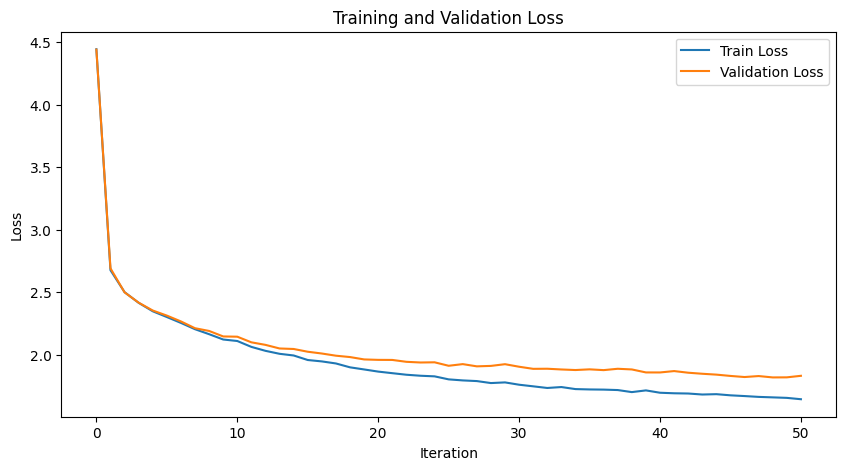

In [ ]:
## Model Training

model = BigramLanguageModel()
m = model.to(device)  # Move the model to the GPU

# Print the number of model parameters
print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')

# Check data types of model parameters
# for name, param in model.named_parameters():
#     print(f"Parameter: {name}, DataType: {param.dtype}")

# Train the model
# Create an AdamW optimizer with the specified learning rate, passing in the model parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize lists to store loss values
train_losses = []
val_losses = []

for iter in range(max_iters):
    # Evaluate and print training/validation loss every eval_interval iterations
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # Sample a batch of training data
    xb, yb = get_batch('train')

    # Forward pass: compute logits and loss
    logits, loss = model(xb, yb)

    # Zero gradients (PyTorch accumulates by default)
    optimizer.zero_grad(set_to_none=True)

    # Backward pass: compute gradients
    loss.backward()

    # Update model parameters
    optimizer.step()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the loss plot
plt.savefig('loss_plot.png')

# Generate new text from a blank context
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))
